## Prepare Notebook

In [19]:
# Main data packages. 
import numpy as np
import pandas as pd
# Data Viz. 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## Read Data

In [20]:
from pathlib import Path

file_path = Path('../../../data/basel_weather.csv')

raw_df = pd.read_csv(file_path)

data_df = raw_df.copy()

data_df = data_df.rename(columns={
    'Basel Temperature [2 m elevation corrected]': 'temperature', 
    'Basel Precipitation Total': 'precipitation', 
    'Basel Wind Speed [10 m]': 'wind_speed', 
    'Basel Wind Direction [10 m]': 'wind_direction'
    }
)

data_df = data_df.assign(
    timestamp = lambda x: pd.to_datetime(x['timestamp']), 
    date = lambda x: x['timestamp'].dt.date,
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    dayofyear = lambda x: x['timestamp'].dt.dayofyear,
    hour = lambda x: x['timestamp'].dt.hour,
)

# Next, we aggregate by day. 
daily_data_df = data_df \
    .groupby(['date', 'year', 'month', 'day', 'dayofyear'], as_index=False)\
    .agg({'temperature': np.mean}) \
    .assign(date = lambda x: pd.to_datetime(x['date']))

daily_data_df.head()

,date,year,month,day,dayofyear,temperature
0,2008-01-01,2008,1,1,1,1.504620
1,2008-01-02,2008,1,2,2,-0.716971
2,2008-01-03,2008,1,3,3,1.312195
3,2008-01-04,2008,1,4,4,3.012195
4,2008-01-05,2008,1,5,5,7.090529


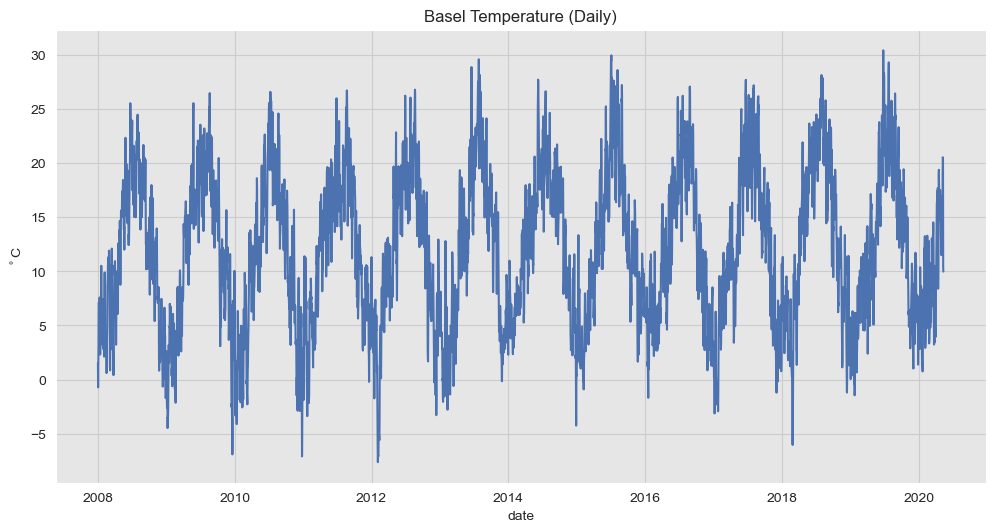

In [21]:
# Plot daily data. 
fig, ax = plt.subplots()
sns.lineplot(x='date', y='temperature', data=daily_data_df, ax=ax)
ax.set(title='Basel Temperature (Daily)', ylabel=r'$^\circ$C');

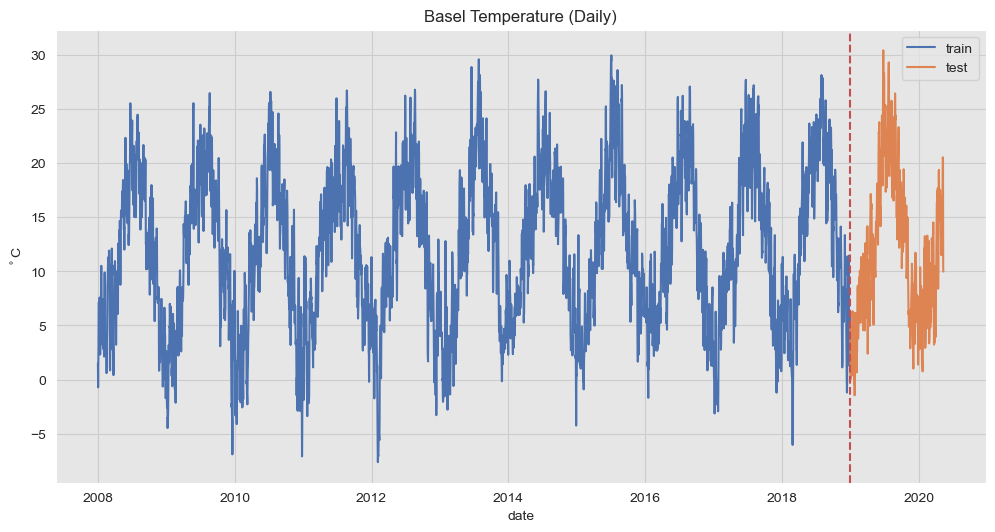

In [22]:
train_test_cut_date = '2019-01-01'
df_train = daily_data_df.query(f'date < "{train_test_cut_date}"')
df_test = daily_data_df.query(f'date >= "{train_test_cut_date}"')

fig, ax = plt.subplots()
sns.lineplot(x='date', y='temperature', data=df_train, color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x='date', y='temperature', data=df_test, color=sns_c[1], label='y_test', ax=ax)
ax.axvline(x=train_test_cut_date, linestyle='--', color=sns_c[3], label='train-test-split')
ax.set(title='Basel Temperature (Daily)', ylabel=r'$^\circ$C');

In [29]:
y_train = df_train['temperature'].to_numpy()
t_train = df_train['date'].to_numpy()
y_test =df_test['temperature'].to_numpy()
t_test = df_test['date'].to_numpy()

In [120]:
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing

arima_model = STLForecast(
    endog=y_train,
    period=365, 
    model=ARIMA,
    model_kwargs={'order': (2, 1, 1)},
    trend_deg=1
)

es_model = STLForecast(
    endog=y_train,
    period=365, 
    model=ExponentialSmoothing,
    model_kwargs={'trend': True}, 
    trend_deg=1
)

arima_result = arima_model.fit()
es_result = es_model.fit()

In [121]:
y_pred_arima = arima_result.forecast(y_test.size)
y_pred_es = es_result.forecast(y_test.size)

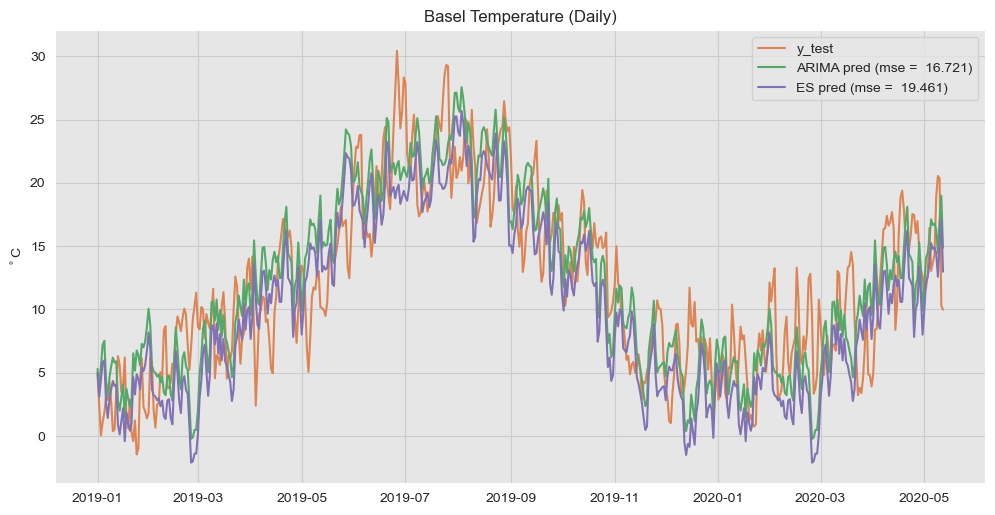

In [122]:
from sklearn.metrics import mean_squared_error

mse_arima = mean_squared_error(y_true=y_test, y_pred=y_pred_arima)
mse_es = mean_squared_error(y_true=y_test, y_pred=y_pred_es)

fig, ax = plt.subplots()
sns.lineplot(x=t_test, y=y_test, color=sns_c[1], label='y_test', ax=ax)
sns.lineplot(x=t_test, y=y_pred_arima, color=sns_c[2], label=f'ARIMA pred (mse = {mse_arima: 0.3f})', ax=ax)
sns.lineplot(x=t_test, y=y_pred_es, color=sns_c[4], label=f'ES pred (mse = {mse_es: 0.3f})', ax=ax)
ax.set(title='Basel Temperature (Daily)', ylabel=r'$^\circ$C');